# Lab3
Noam Yan

## Problem 1
1.A

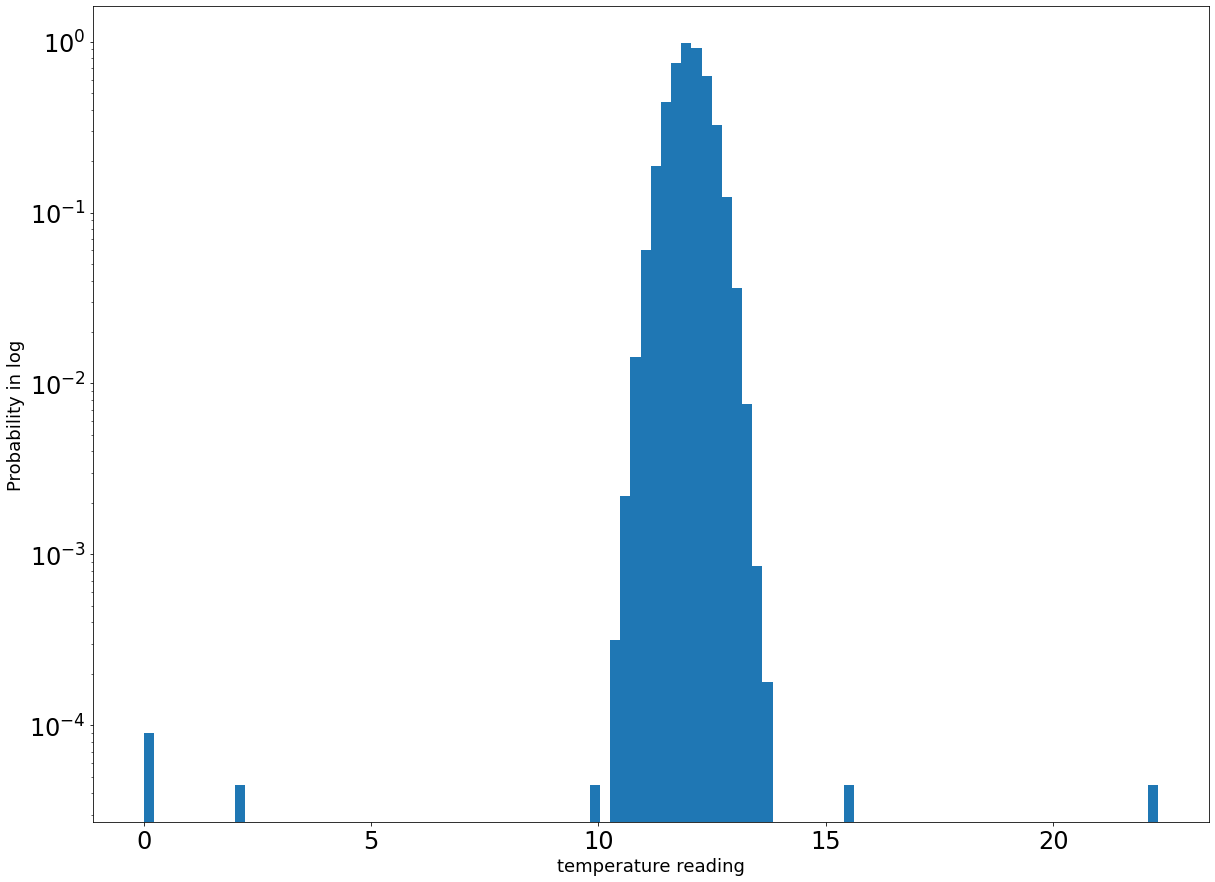

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import stats as stats
import pandas as pd

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)
norm_dist = stats.norm.rvs(loc = 12., scale = 0.4, size = 100000)
d = np.append(norm_dist, [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.xlabel("temperature reading", fontsize=18)
plt.ylabel("Probability in log", fontsize=18)
plt.tick_params(labelsize = 24)
plt.yscale('log')
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.show()

In [2]:
# get the range of normal distribution
_,minmax,_,_,_,_ = stats.describe(norm_dist)
print(d.shape)

(100008,)


In [3]:
def detectOutliers(minmax,data):
    outliers = []
    for ele in data:
        if ele>= minmax[0] and ele<=minmax[1]:
            continue
        else: 
            outliers.append(ele)
    return outliers

def rejectOutliers(minmax,data):
    index = []
    for i,ele in enumerate(data):
        if ele>= minmax[0] and ele<=minmax[1]:
            continue
        else: 
            index.append(i)
    data = np.delete(d,index)
    return data

outliers = detectOutliers(minmax,d)
validValue = rejectOutliers(minmax,d)
print("We have %d outliers, which are %s"%(len(outliers),outliers))
print("and %d valid values"%len(validValue))

We have 7 outliers, which are [10.0, 10.3, 2.1, 0.0, 0.0, 15.6, 22.3]
and 100001 valid values


2. The statistical question is "What is the threshold that the valid value are in the range (12±threshold) and outliers are excluded?"<br>
3. setting up a range (12-threshold,12+threshold), if the elements in this range is also in normal distribution, then it is TruePositive, otherwise, FalsePositve; if the elements out of this range is also out of the nomal distribution, then it is TrueNegative, otherwise FalseNegative.
4. Choose threshold = 1.2

In [4]:
def eval(threshold,data,trueNeg,truePos):
    minmax = (12-threshold,12+threshold)
    predNeg = detectOutliers(minmax,data)
    predPos = rejectOutliers(minmax,data)
    
    N = len(predNeg)
    P = len(predPos)
    
    TP,FP,FN,TN = 0,0,0,0
    
    for pos in predPos:
        if pos in truePos:
            TP+=1
    FP = P - TP
    
    for neg in predNeg:
        if neg in trueNeg:
            TN+=1
    FN = N - TN
        
    return TP,FP,FN,TN

In [5]:
threshold = 1.2
TP,FP,FN,TN = eval(threshold,d,outliers,validValue)
pd.DataFrame({"True T": [TP,FN],"Bad T":[FP,TN]},index=['Your Test Good','Your Test Bad'])

,True T,Bad T
Your Test Good,99723,0
Your Test Bad,278,7


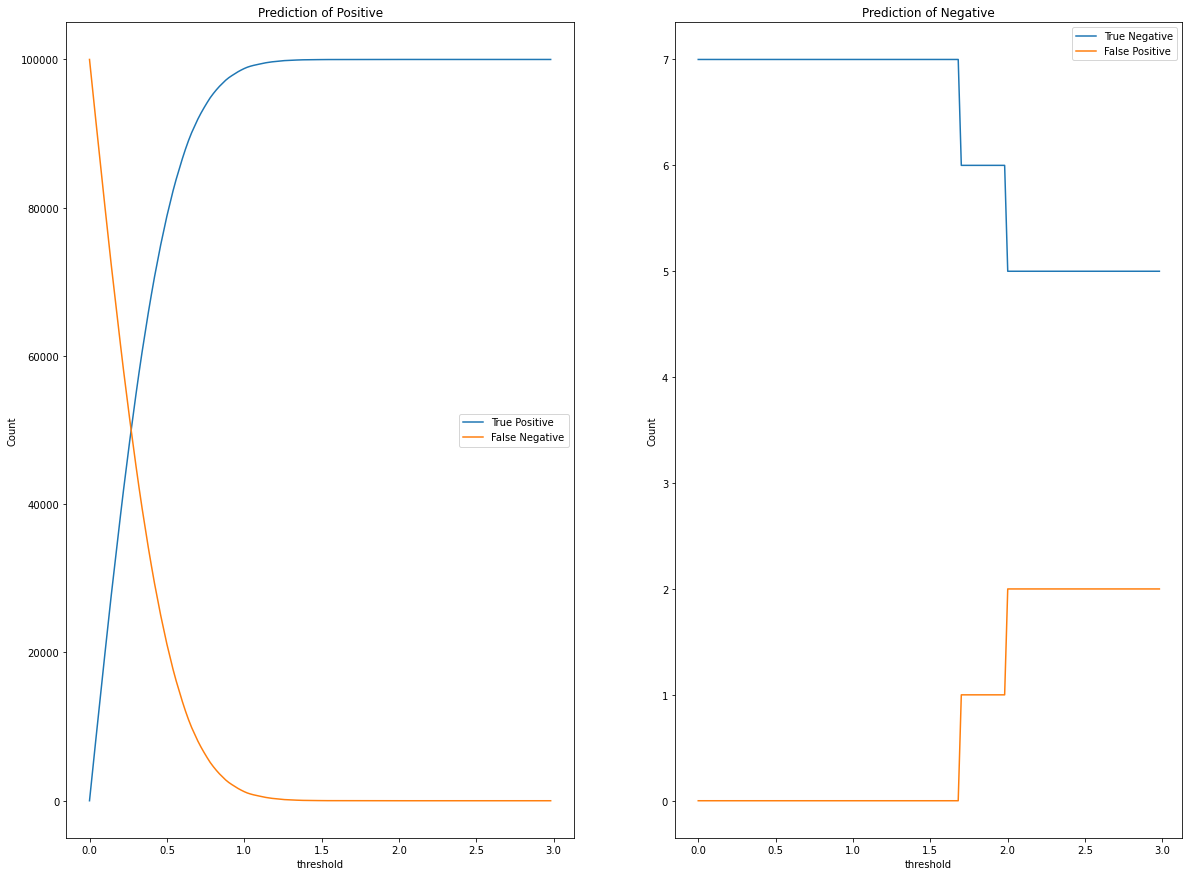

In [6]:
# plt.rcParams["figure.figsize"] = (12,30)
thresholds = np.arange(0,3,.02)
fig,ax=plt.subplots(1, 2)
posList = []
negList = []
for threshold in thresholds:
    TP,FP,FN,TN = eval(threshold,d,outliers,validValue)
    posList.append([TP,FP])
    negList.append([TN,FN])

posList = np.transpose(posList,(1,0))
negList = np.transpose(negList,(1,0))

ax[0].plot(thresholds,posList[0],label="True Positive")
ax[0].plot(thresholds,negList[1],label="False Negative")
ax[1].plot(thresholds,negList[0],label="True Negative")
ax[1].plot(thresholds,posList[1],label="False Positive")
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Count")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Count")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Prediction of Positive")
ax[1].set_title("Prediction of Negative")
plt.setp(ax,xlabel="threshold")
plt.show()

B) As threshold increses, FN decreases, which means less positive samples are dropped.When the threshold is greater than 1.5, almost every sample has been seen as positive -- there is no omission, so it is predictable.

C) Yes,when threshold is greater than 1.7, bad data becomes getting in. That is also why we need precission. This situation can be avoid by choosing a smaller threshold. <br><br>
This is an interesting tradeoff, if you set the threshold too large, you will get a high recall (TP/ (TP+FN)) and omit few positive samples. Especially, if you set threshold to infinity, everything will be seen as positive and you recall=100%, but the precission (TP/ (TP+FP)) is very low. On the other hand, if you set the threshold too small, you omit a lot of true positive sample, the precision will be very high, but recall is low.

## Problem 2

1. Question: What is the distance from the origin of 2D Gaussian corresponding to 5σ as significance.<br>
2. First we need to calculate the probability of 5σ in Standard Normal Distribution.Then we come up with a question: what is the x-value in 2D Gaussian coresponding to such probability.<br>
3. 

In [7]:
# We know that 2D Standard Gaussian is Standard Rayleigh, so we can use Rayleigh inverse survival funtion.
prob = stats.norm.sf(5)
x = stats.rayleigh.isf(prob)
print("The distance from the origin of 2D Gaussian corresponding to 5σ as significance is %.3f arcseconds."%x)

The distance from the origin of 2D Gaussian corresponding to 5σ as significance is 5.489 arcseconds.


## Problem 3

The amount of cosmic ray we receive per minute should be a poisson distribution with mean = 1. We have 15* 8* 60=7200 minutes for total, so we sum convolve the pmf 7200 times.<br>
1. Question: What is the probability of the convolved distribution giving a measurement that is equally or more signal like than the observation 6800 cosmic rays?
2. Question in Math: What is the integral of the convolved pmf from 6800 to infinity. Alternatively, we can just add all the pmf value whose x >= 6800.

In [8]:
def _conv (xrange, sumOrAvg, pdf, times):
    '''
    sumOrAvg:  0 means sum, 1 means Avg.
    times: can be a list or an integer.
    '''
    conv_pdf = pdf
    if type(times) is int:
        for i in range(times-1):
            conv_pdf = np.convolve(conv_pdf,pdf)
        conv_xrange = np.linspace(xrange[0]*times,xrange[-1]*times, conv_pdf.shape[0]) if sumOrAvg==0 else np.linspace(xrange[0],xrange[-1], conv_pdf.shape[0])
        return conv_xrange, conv_pdf                                                                                                               
    else:
        ans_dist = {"conv_xrange":[], "conv_pdf":[]}                                                                                                               
        for i in times:
            for j in range(i-1):
                conv_pdf = np.convolve(conv_pdf,pdf)
            conv_xrange = np.linspace(xrange[0]*i,xrange[-1]*i, conv_pdf.shape[0]) if sumOrAvg==0 else np.linspace(xrange[0],xrange[-1], conv_pdf.shape[0])
            ans_dist['conv_xrange'].append(conv_xrange)
            ans_dist['conv_pdf'].append(conv_pdf)
        return ans_dist['conv_xrange'], ans_dist['conv_pdf']

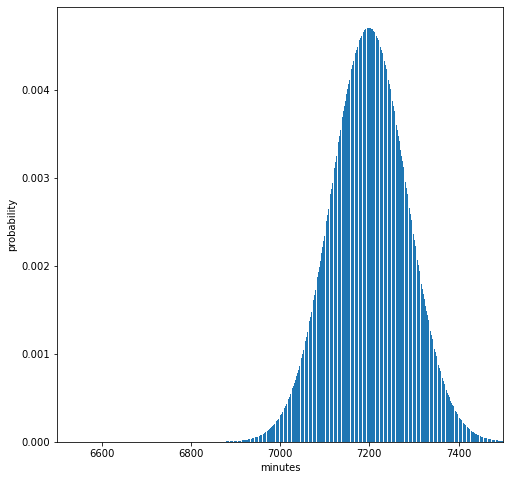

In [12]:
plt.rcParams["figure.figsize"] = (8,8)
xrange = np.arange(0,8,1)
time = 8*60*15
pmf = stats.poisson.pmf(xrange,1)

conv_xrange,conv_pmf = _conv(xrange,0,pmf,time)
plot_pmf = conv_pmf/np.sum(conv_pmf)
fig, ax = plt.subplots(1, 1)
ax.bar(conv_xrange,plot_pmf)
plt.xlim([6500,7500])
plt.xlabel("minutes")
plt.ylabel("probability")
plt.show()

In [13]:
indices = np.argwhere(conv_xrange>=6800)
prob_cr = np.sum(conv_pmf[indices])
print("The probability of the convolved distribution giving a measurement that is equally or more signal like than the observation 6800 cosmic rays is less than %.3g"%prob_cr)

The probability of the convolved distribution giving a measurement that is equally or more signal like than the observation 6800 cosmic rays is less than 0.929


In [14]:
x = stats.norm.isf(prob_cr)
print("The significance of our moon shadow detection is %.2fσ"%x)

The significance of our moon shadow detection is -1.47σ
